In [ ]:
IBM real  ibm_brisbane 05/02/2025

In [11]:
import qiskit
print(qiskit.__version__)

1.3.2


In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler



In [2]:
# Funciones auxiliares

def f_simple_sum(circ, lista):
    """Suma dos qubits y almacena el resultado en un tercer qubit."""
    for array in lista:
        circ.cx(array[0], array[2])
        circ.cx(array[1], array[2])
        circ.barrier()

def f_sum_not_two(circ, lista):
    """Asegura que la suma de dos qubits no sea 2."""
    for array in lista:
        circ.x(array[2])
        circ.ccx(array[0], array[1], array[2])
        circ.barrier()

def f_sum_three_is_one(circ, lista):
    """Verifica que la suma de tres qubits sea 1."""
    for array in lista:
        circ.cx(array[0], array[3])
        circ.cx(array[1], array[3])
        circ.cx(array[2], array[3])
        circ.ccx(array[0], array[1], array[4])
        circ.ccx(array[2], array[4], array[3])
        circ.ccx(array[0], array[1], array[4])
        circ.barrier()

def f_check_all_one(circ, lista):
    """Marca el qubit de solución si todos los anteriores son 1."""
    for array in lista:
        circ.ccx(array[0], array[1], array[8])
        for i in range(6):
            circ.ccx(array[2 + i], array[8 + i], array[9 + i])
        circ.cx(array[-2], array[-1])
        for i in range(5, -1, -1):
            circ.ccx(array[2 + i], array[8 + i], array[9 + i])
        circ.ccx(array[0], array[1], array[8])
        circ.barrier()

def add_grover(circ, free):
    """Agrega el operador de Grover para amplificar las soluciones correctas."""
    lista = list(range(6))
    first_free_qubit = free

    circ.h(lista)
    circ.x(lista)
    circ.barrier()

    circ.ccx(lista[0], lista[1], first_free_qubit)
    for i in range(len(lista) - 3):
        circ.ccx(lista[i+2], first_free_qubit + i, first_free_qubit + 1 + i)
        j = i
    circ.cz(first_free_qubit + 1 + j, lista[-1])
    for i in range(len(lista) - 4, -1, -1):
        circ.ccx(lista[i+2], first_free_qubit + i, first_free_qubit + 1 + i)
    circ.ccx(lista[0], lista[1], first_free_qubit)

    circ.barrier()
    circ.x(lista)
    circ.h(lista)
    circ.barrier()


In [3]:
# Definir restricciones del problema N-Reinas
simple_sum = [[0, 1, 6], [2, 3, 7], [4, 5, 8], [2, 4, 9]]
diagonals = [[0, 2, 10], [1, 2, 11]]
three_sum = [[1, 3, 5, 12, 13]]
criteria_solutions = [[0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

# Crear registros cuánticos y clásicos
num_qubits = 26
qreg = QuantumRegister(num_qubits, "q")
creg = ClassicalRegister(6, "c")
circ = QuantumCircuit(qreg, creg)

# Aplicar restricciones
f_simple_sum(circ, simple_sum)
f_sum_not_two(circ, diagonals)
f_sum_three_is_one(circ, three_sum)

# Aplicar verificación de soluciones
f_check_all_one(circ, criteria_solutions)
circ.z(20)

# Deshacer operaciones auxiliares
f_check_all_one(circ, criteria_solutions)
f_sum_three_is_one(circ, three_sum)
f_sum_not_two(circ, diagonals)
f_simple_sum(circ, simple_sum)

# Aplicar operador de Grover
add_grover(circ, 22)

#  Crear el circuito final
circuito = QuantumCircuit(qreg, creg)

# Superposición inicial
circuito.h(range(6))

# Aplicar el circuito de Grover 8 veces
for _ in range(8):
    circuito.compose(circ, inplace=True)

# Medición
circuito.measure(range(6), range(6))

#  Conexión con IBMQ y autenticación con tu token

# Cargar la cuenta de IBM Quantum con tu token
token = "TOKEN"  # Reemplaza con tu token
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# Seleccionar el backend real de IBM Quantum
backend = service.backend('ibm_brisbane')  # O el que tengas disponible

# Transpilar el circuito para el backend específico
transpiled_circuit = transpile(circuito, backend)

# Usar Qiskit Runtime Service para ejecutar el circuito
sampler = Sampler(mode=backend) 
job = sampler.run([transpiled_circuit], shots=1024)

# Obtener los resultados
result = job.result()


In [4]:
circuito.draw("mpl")
#Circuito traspilado no se puede mostrar al ser demasiado grande
#transpiled_circuit.draw("mpl")

In [5]:
counts = result[0].data.c.get_counts()
plot_histogram(counts)
circ
# Obtener la mejor solución
resultado = max(counts, key=counts.get)
print("Solución:", resultado)

#  Función para visualizar la solución en un tablero
def plot(valor):
    matriz = np.zeros([4, 4])
    matriz[2][0] = 1
    matriz[0][1] = int(valor[-1])
    matriz[0][3] = int(valor[-2])
    matriz[1][2] = int(valor[-3])
    matriz[1][3] = int(valor[-4])
    matriz[3][2] = int(valor[-5])
    matriz[3][3] = int(valor[-6])

    print(" --------------- ")
    for i in range(4):
        print("|", end="")
        for j in range(4):
            if matriz[i][j] == 0:
                print("   |", end="")
            else:
                print(" X |", end="")
        print()
        print(" --------------- ")

# Mostrar la solución en el tablero
plot(resultado)

Solución: 001011
 --------------- 
|   | X |   | X |
 --------------- 
|   |   |   | X |
 --------------- 
| X |   |   |   |
 --------------- 
|   |   |   |   |
 --------------- 


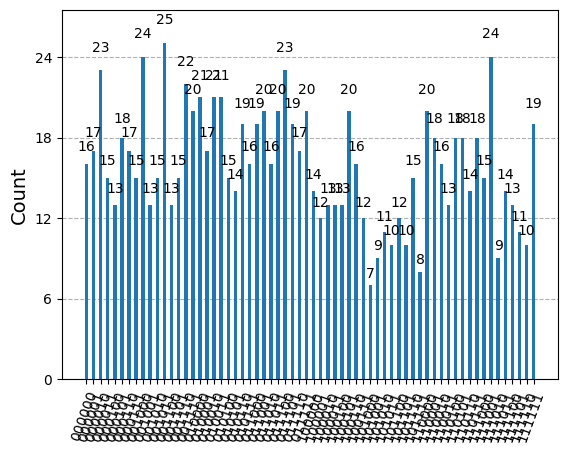

In [6]:
from qiskit.visualization import plot_histogram

from IPython.display import display
display(plot_histogram(counts))

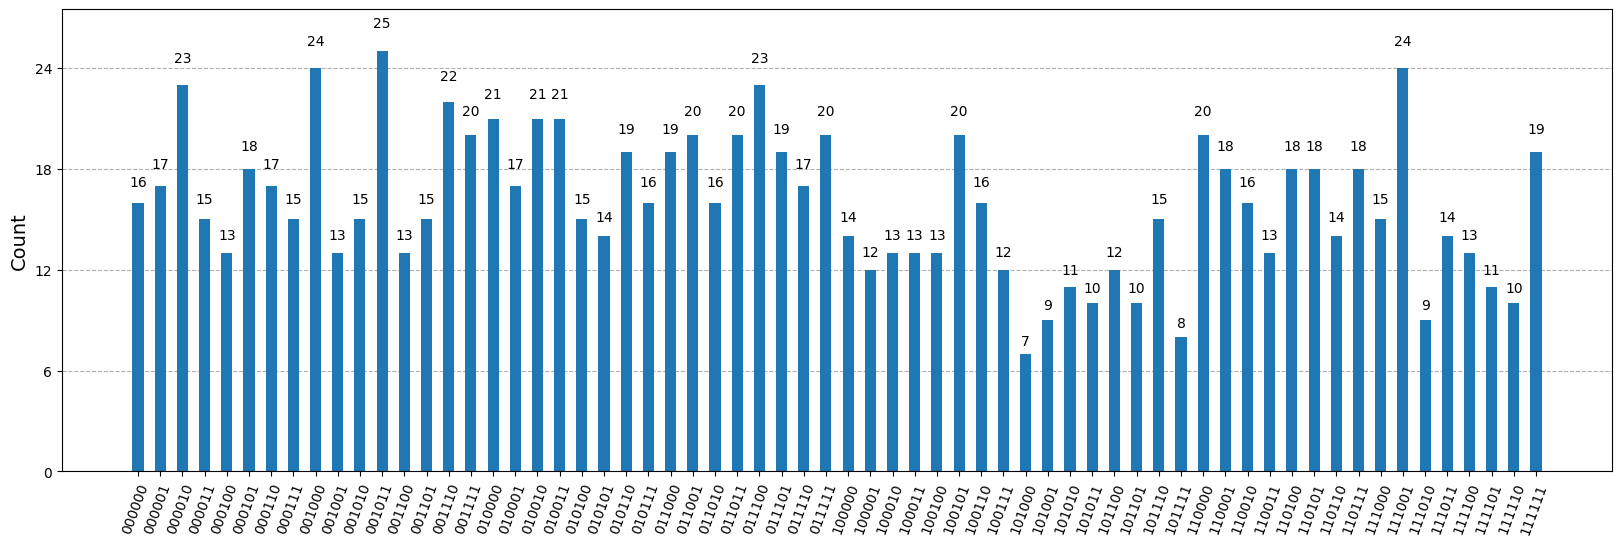

In [12]:
from qiskit.visualization import plot_histogram
from IPython.display import display

# Ajusta el tamaño: (ancho, alto) en pulgadas
display(plot_histogram(counts, figsize=(20, 6)))

In [8]:
print(counts)

{'001101': 15, '100011': 13, '010010': 21, '000001': 17, '000110': 17, '010100': 15, '011111': 20, '000101': 18, '101010': 11, '010001': 17, '110111': 18, '001011': 25, '110110': 14, '111000': 15, '010101': 14, '000000': 16, '000100': 13, '100100': 13, '011001': 20, '001110': 22, '011100': 23, '000111': 15, '111011': 14, '100101': 20, '101000': 7, '011010': 16, '010011': 21, '110000': 20, '100110': 16, '011011': 20, '011110': 17, '010110': 19, '110100': 18, '010000': 21, '100000': 14, '111001': 24, '101001': 9, '001001': 13, '110011': 13, '101100': 12, '000011': 15, '110010': 16, '001000': 24, '000010': 23, '101110': 15, '011000': 19, '001100': 13, '101101': 10, '011101': 19, '010111': 16, '001111': 20, '100010': 13, '110001': 18, '111111': 19, '100111': 12, '101011': 10, '111110': 10, '111101': 11, '101111': 8, '100001': 12, '111100': 13, '001010': 15, '110101': 18, '111010': 9}


In [21]:
from qiskit import QuantumCircuit
from qiskit import qasm3


# Obtener la representación QASM usando qasm_output()
qasm_str = qasm3.dumps(circuito, experimental=qasm3.ExperimentalFeatures.SWITCH_CASE_V1)

# Guardar el QASM en un archivo de texto
with open("Reinas_IBM.qasm", "w") as archivo:
    archivo.write(qasm_str)

print("Circuito guardado en Reinas_IBM.qasm")


Circuito guardado en Reinas_IBM.qasm


In [10]:
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram

# --- Parámetros y resultados del experimento ---
num_shots = 1024  # Ajusta según tu experimento
counts = counts

# Tiempo de ejecución desde metadatos (en milisegundos)
execution_start = result.metadata['execution']['execution_spans'][0].start
execution_end = result.metadata['execution']['execution_spans'][0].stop
execution_time = (execution_end - execution_start).total_seconds() * 1000
t_sample = execution_time / num_shots

# Mostrar histograma
plot_histogram(counts)

# --- Función para validar soluciones óptimas de 4 reinas con reina fija en (2,0) ---
def is_valid_solution(sol_str):
    # Debe tener exactamente 3 unos para completar 4 reinas (1 fija)
    if sol_str.count('1') != 3:
        return False

    matriz = [[0]*4 for _ in range(4)]
    matriz[2][0] = 1

    posiciones = [
        (0, 1),  # bit -1
        (0, 3),  # bit -2
        (1, 2),  # bit -3
        (1, 3),  # bit -4
        (3, 2),  # bit -5
        (3, 3)   # bit -6
    ]

    for i, (r, c) in enumerate(posiciones):
        if sol_str[-1 - i] == '1':
            matriz[r][c] = 1

    reinas = [(r, c) for r in range(4) for c in range(4) if matriz[r][c] == 1]

    for i in range(len(reinas)):
        for j in range(i+1, len(reinas)):
            r1, c1 = reinas[i]
            r2, c2 = reinas[j]
            if r1 == r2 or c1 == c2 or abs(r1 - r2) == abs(c1 - c2):
                return False

    return True

# --- Extraer soluciones óptimas ---
opt_solutions = [bitstr for bitstr in counts if is_valid_solution(bitstr)]

# --- Calcular P_GS y TTS ---
def calculate_P_GS_and_TTS(counts, opt_states, t_sample):
    success_counts = sum(counts.get(state, 0) for state in opt_states)
    total_counts = sum(counts.values())
    p_gs = success_counts / total_counts if total_counts > 0 else 0

    if p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))

    return p_gs, tts

# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(counts, opt_solutions, t_sample)

# --- Mostrar resultados en tabla ---
df = pd.DataFrame({
    "Instance": ["4x4-Queens"],
    "Opt": [len(opt_solutions)],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})

print("Soluciones óptimas encontradas:", opt_solutions)
display(df)


Soluciones óptimas encontradas: ['011001']


Instance  Opt      P_GS  t_sample (ms)     TTS (ms)
0  4x4-Queens    1  0.019531       6.774877  1581.761408